## Introduction: Machine Learning Project Part 2

#### In this series of notebooks, we are working on a supervised, regression machine learning problem. Using real-world New York City building energy data, we want to predict the Energy Star Score of a building and determine the factors that influence the score.

#### We are using the general outline of the machine learning pipeline to structure our project:
#### 1. Data cleaning and formatting
#### 2. Exploratory data analysis
#### 3. Feature engineering and selection
#### 4. Compare several machine learning models on a performance metric
#### 5. Perform hyperparameter tuning on the best model to optimize it for the problem
#### 6. Evaluate the best model on the testing set
#### 7. Interpret the model results to the extent possible
#### 8. Draw conclusions and write a well-documented report

## Imports

In [4]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [7]:
%%HTML
    <style type="text/css">
        table.dataframe td, table.dataframe th {
            border-style: solid;
        }
</style>

### Read in Data

In [5]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


#### As a reminder, here is what the formatted data looks like. In the first notebook, we engineered a number features by taking the natural log of the variables, included two categorical variables, and selected a subset of features by removing highly collinear features.

In [6]:
train_features.head()

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### The score column contains the Energy Star Score, the target for our machine learning problem. The Energy Star Score is supposed to be a comparitive measurement of the energy efficiency of a building, although we saw there may be issues with how this is calculated in part one!
##### Here's the distribution of the Energy Star Score.

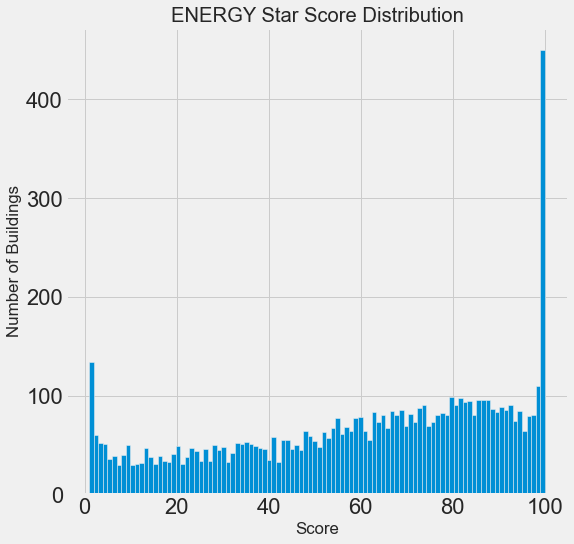

In [8]:
figsize(8, 8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('ENERGY Star Score Distribution');

### Evaluating and Comparing Machine Learning Models

##### In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning).

##### We are comparing models using the mean absolute error. A baseline model that guessed the median value of the score was off by an average of 25 points.

### Imputing Missing Values

##### Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill these in or disard any features with missing values. Since we already removed features with more than 50% missing values in the first part, here we will focus on filling in these missing values

In [10]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [11]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


### Scaling Features

##### The final step to take before we can build our models is to scale the features. This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. Linear Regression and Random Forest do not require feature scaling, but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms.

In [12]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [13]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

### Models to Evaluate

##### We will compare five different machine learning models using the great Scikit-Learn library:

##### 1. Linear Regression
##### 2. Support Vector Machine Regression
##### 3. Random Forest Regression
##### 4. Gradient Boosting Regression
##### 5. K-Nearest Neighbors Regression

In [14]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [15]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [16]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [17]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 9.5231


In [18]:

gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0116


In [19]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


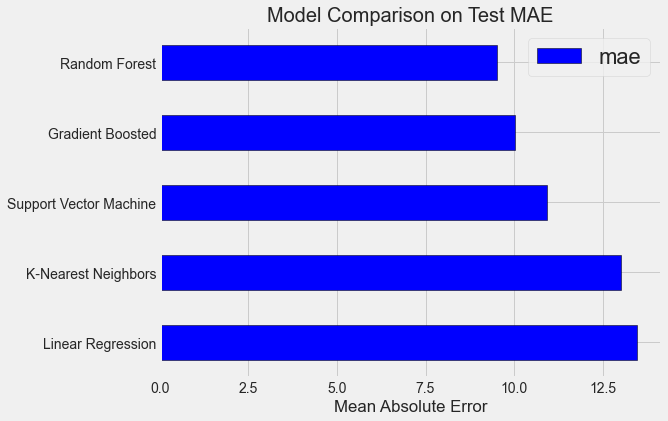

In [20]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

##### Depending on the run (the exact results change slighty each time), the gradient boosting regressor performs the best followed by the random forest. I have to admit that this is not the most fair comparison because we are using mostly the default hyperparameters. Especially with the Support Vector Regressor, the hyperparameters have a significant influence on performance. (the random forest and gradient boosting methods are great for starting out because the performance is less dependent on the model settings). Nonetheless, from these results, we can conclude that machine learning is applicable because all the models significantly outperform the baseline!

### Model Optimization

##### Model hyperparameters are best thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or the number of neighbors used in K Nearest Neighbors Regression.
##### Model parameters are what the model learns during training, such as the weights in the linear regression.

### Hyperparameter Tuning with Random Search and Cross Validation

##### We can choose the best hyperparameters for a model through random search and cross validation.

##### Random search refers to the method in which we choose hyperparameters to evaluate: we define a range of options, and then randomly select combinations to try. This is in contrast to grid search which evaluates every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyperparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options.
##### Cross validation is the method used to assess the performance of the hyperparameters. Rather than splitting the training set up into separate training and validation sets which reduces the amount of training data we can use, we use K-Fold Cross Validation. This means dividing the training data into K folds, and then going through an iterative process where we first train on K-1 of the folds and then evaluate performance on the kth fold. We repeat this process K times so eventually we will have tested on every example in the training data with the key that each iteration we are testing on data that we did not train on. At the end of K-fold cross validation, we take the average error on each of the K iterations as the final performance measure and then train the model on all the training data at once. The performance we record is then used to compare different combinations of hyperparameters

In [21]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

##### In the code below, we create the Randomized Search Object passing in the following parameters:

##### estimator: the model
##### aram_distributions: the distribution of parameters we defined
##### cv the number of folds to use for k-fold cross validation
##### n_iter: the number of different combinations to try
##### scoring: which metric to use when evaluating candidates
##### n_jobs: number of cores to run in parallel (-1 will use all available)
##### verbose: how much information to display (1 displays a limited amount)
##### return_train_score: return the training score for each cross-validation fold
##### random_state: fixes the random number generator used so we get the same results every run
##### The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can compare all the different hyperparameter combinations and find the best performing one.

In [22]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [ ]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)
random_results.head()

In [ ]:
random_cv.best_estimator_

##### Using random search is a good method to narrow down the possible hyperparameters to try. Initially, we had no idea which combination would work the best, but this at least narrows down the range of options.

##### We could use the random search results to inform a grid search by creating a grid with hyperparameters close to those that worked best during the randomized search. However, rather than evaluating all of these settings again, I will focus on a single one, the number of trees in the forest (n_estimators). By varying only one hyperparameter, we can directly observe how it affects performance. In the case of the number of trees, we would expect to see a significant affect on the amount of under vs overfitting.

##### Here we will use grid search with a grid that only has the n_estimators hyperparameter. We will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best values returned from random search to isolate the number of trees effect.

In [ ]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [ ]:
# Fit the grid search
grid_search.fit(X, y)

In [ ]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [ ]:
results.sort_values('mean_test_score', ascending = False).head()

##### From this plot, it's pretty clear that our model is overfitting! The training error is significantly lower than the testing error, which shows that the model is learning the training data very well but then is not able to generalize to the test data as well. Moveover, as the number of trees increases, the amount of overfitting increases. Both the test and training error decrease as the number of trees increase but the training error decreases more rapidly.
##### Based on the cross validation results, the best model using 800 trees and achieves a cross validation error under 9. This indicates that the average cross-validation estimate of the Energy Star Score is within 9 points of the true answer!

### Evaluate Final Model on the Test Set

##### We will use the best model from hyperparameter tuning to make predictions on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world.

##### For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set.

In [ ]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

In [ ]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

##### The final model does out-perform the baseline model by about 10%, but at the cost of significantly increased running time (it's about 12 times slower on my machine). Machine learning is often a field of tradeoffs: bias vs variance, acccuracy vs interpretability, accuracy vs running time, and the final decision of which model to use depends on the situation. Here, the increase in run time is not an impediment, because while the relative difference is large, the absolute magnitude of the training time is not significant. In a different situation, the balance might not be the same so we would need to consider what we are optimizing for and the limitations we have to work with.

##### To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values on the test set.

In [ ]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

##### The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median.

##### Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low).

In [ ]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

###### The residuals are close to normally disributed, with a few noticeable outliers on the low end. These indicate errors where the model estimate was far below that of the true value.

### Conclusions

## In this notebook, we covered crucial concepts in the machine learning pipeline:

##### 1. Imputing missing values
##### 2. Evaluating and comparing several machine learning methods
##### 3. Hyperparameter tuning a machine learning model using random search and cross validation
##### 4. Evaluating the best model on the testing set
###### The results showed us that machine learning is applicable to our problem, with the final model able to the predict the Energy Star Score of a building to within 9.1 points. We also saw that hyperparamter tuning was able to improve the performance of the model although at a considerable cost in terms of time invested. This is a good reminder that proper feature engineering and gathering more data (if possible!) has a much larger pay-off than fine-tuning the model. We also observed the trade-off in run-time versus accuracy, which is one of many considerations we have to take into account when designing machine learning models.